In [1]:
# CELL 1: THE "TRAINER" SCRIPT
# -----------------------------------------------
# This script ONLY trains our models and saves them to disk.
# It NEVER imports 'shap' and will not cause the error.
#
# INSTRUCTIONS FOR COLAB:
# 1. Ensure `Runtime > Change runtime type` is set to `T4 GPU`.
# 2. Ensure 'KDDTrain+.txt' and 'KDDTest+.txt' are uploaded.
# 3. Run this cell and wait for it to complete.

# Step 1: Import All Training Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib # Library to save our scikit-learn model
import pickle # Library to save our data

print("--- Phase 3 (V7-Trainer): Starting Model Training ---")
print(f"TensorFlow Version: {tf.__version__}")
print("-" * 30)

# Step 2: Define Column Names and Load Data
if not (os.path.exists('KDDTrain+.txt') and os.path.exists('KDDTest+.txt')):
    print("--- ERROR ---")
    print("Please upload 'KDDTrain+.txt' and 'KDDTest+.txt' using the file sidebar on the left.")
    print("-" * 30)
else:
    print("--- Data Files Found. Loading... ---")
    col_names = [
        'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
        'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
        'num_compromised', 'root_shell', 'su_attempted', 'num_root',
        'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
        'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
        'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
        'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
        'dst_host_srv_count', 'dst_host_same_srv_rate',
        'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
        'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
        'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
        'dst_host_srv_rerror_rate', 'label', 'difficulty'
    ]
    train_data = pd.read_csv('KDDTrain+.txt', header=None, names=col_names)
    test_data = pd.read_csv('KDDTest+.txt', header=None, names=col_names)
    train_data = train_data.drop('difficulty', axis=1)
    test_data = test_data.drop('difficulty', axis=1)
    print("--- Data Loading Successful ---")
    print("-" * 30)


    # Step 3: Data Preprocessing (Combined)
    print("--- Starting Data Preprocessing ---")
    train_data['label'] = train_data['label'].apply(lambda x: 0 if x == 'normal' else 1)
    test_data['label'] = test_data['label'].apply(lambda x: 0 if x == 'normal' else 1)
    categorical_cols = ['protocol_type', 'service', 'flag']
    combined_data = pd.concat([train_data, test_data], axis=0)
    for col in categorical_cols:
        dummies = pd.get_dummies(combined_data[col], prefix=col)
        combined_data = pd.concat([combined_data, dummies], axis=1)
        combined_data.drop(col, axis=1, inplace=True)

    train_processed = combined_data.iloc[:len(train_data)]
    test_processed = combined_data.iloc[len(train_data):]

    y_train = train_processed['label']
    y_test = test_processed['label']
    X_train = train_processed.drop('label', axis=1)
    X_test = test_processed.drop('label', axis=1)

    X_train_cols = X_train.columns
    X_test_cols = X_test.columns
    missing_in_test = set(X_train_cols) - set(X_test_cols)
    for c in missing_in_test:
        X_test[c] = 0
    missing_in_train = set(X_test_cols) - set(X_train_cols)
    for c in missing_in_train:
        X_train[c] = 0
    X_test = X_test[X_train_cols]

    numerical_cols = list(set(col_names) - set(categorical_cols) - set(['label', 'difficulty']))
    scaler = StandardScaler()
    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

    feature_names = X_train.columns.tolist()

    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)

    print("--- Data Preprocessing Complete ---")
    print("-" * 30)


    # Step 4: Re-Train Phase 1 Model (Random Forest)
    print("--- Training Baseline Model (Random Forest) ---")
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_classifier.fit(X_train, y_train)
    print("--- Baseline Model Trained ---")
    print("-" * 30)


    # Step 5: Re-Train Phase 2 Model (LSTM)
    print("--- Training Advanced Model (LSTM) ---")
    X_train_reshaped = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
    X_test_reshaped = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))

    lstm_model = Sequential()
    lstm_model.add(LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(Dense(1, activation='sigmoid'))
    lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    print("Training LSTM (this will take a moment)...")
    history = lstm_model.fit(
        X_train_reshaped,
        y_train,
        epochs=5,
        batch_size=64,
        verbose=1
    )
    print("--- Advanced Model Trained ---")
    print("-" * 30)

    # ------------------------------------------
    # STEP 6: SAVE EVERYTHING TO DISK
    # ------------------------------------------
    print("--- Saving models and data to disk... ---")

    # Save the Random Forest model
    joblib.dump(rf_classifier, 'rf_model.joblib')

    # Save the LSTM model
    lstm_model.save('lstm_model.h5')

    # Save the data needed for explanation
    with open('shap_data.pkl', 'wb') as f:
        pickle.dump({
            'X_train_reshaped': X_train_reshaped,
            'X_test_df': X_test, # Save the DataFrame
            'X_test_reshaped': X_test_reshaped,
            'feature_names': feature_names
        }, f)

    print("--- All files saved! ---")
    print("You should see 'rf_model.joblib', 'lstm_model.h5', and 'shap_data.pkl' in the file sidebar.")
    print("-" * 30)
    print("\n--- Trainer Script Complete. You may now run the 'Explainer' script in a new cell. ---")

--- Phase 3 (V7-Trainer): Starting Model Training ---
TensorFlow Version: 2.19.0
------------------------------
--- Data Files Found. Loading... ---
--- Data Loading Successful ---
------------------------------
--- Starting Data Preprocessing ---
--- Data Preprocessing Complete ---
------------------------------
--- Training Baseline Model (Random Forest) ---
--- Baseline Model Trained ---
------------------------------
--- Training Advanced Model (LSTM) ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training LSTM (this will take a moment)...
Epoch 1/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9553 - loss: 0.1391
Epoch 2/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9915 - loss: 0.0256
Epoch 3/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9927 - loss: 0.0220
Epoch 4/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9936 - loss: 0.0197
Epoch 5/5
1969/1969 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9939 - loss: 0.0175


--- Advanced Model Trained ---
------------------------------
--- Saving models and data to disk... ---
--- All files saved! ---
You should see 'rf_model.joblib', 'lstm_model.h5', and 'shap_data.pkl' in the file sidebar.
------------------------------

--- Trainer Script Complete. You may now run the 'Explainer' script in a new cell. ---



--- SHAP Library Installed ---
SHAP Version: 0.49.1
------------------------------
--- Loading models and data from disk... ---
--- All files loaded successfully! ---
------------------------------
--- Starting XAI Analysis for Random Forest ---
--- Generating Plot 1: Random Forest Feature Importance ---


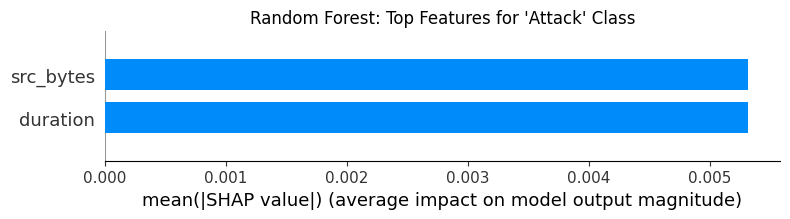

------------------------------
--- Starting XAI Analysis for LSTM ---


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(100, 1, 122))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 1, 122))']
  warnings.warn(msg)


--- Generating Plot 2: LSTM Feature Importance ---


/tmp/ipython-input-1847764667.py:100: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


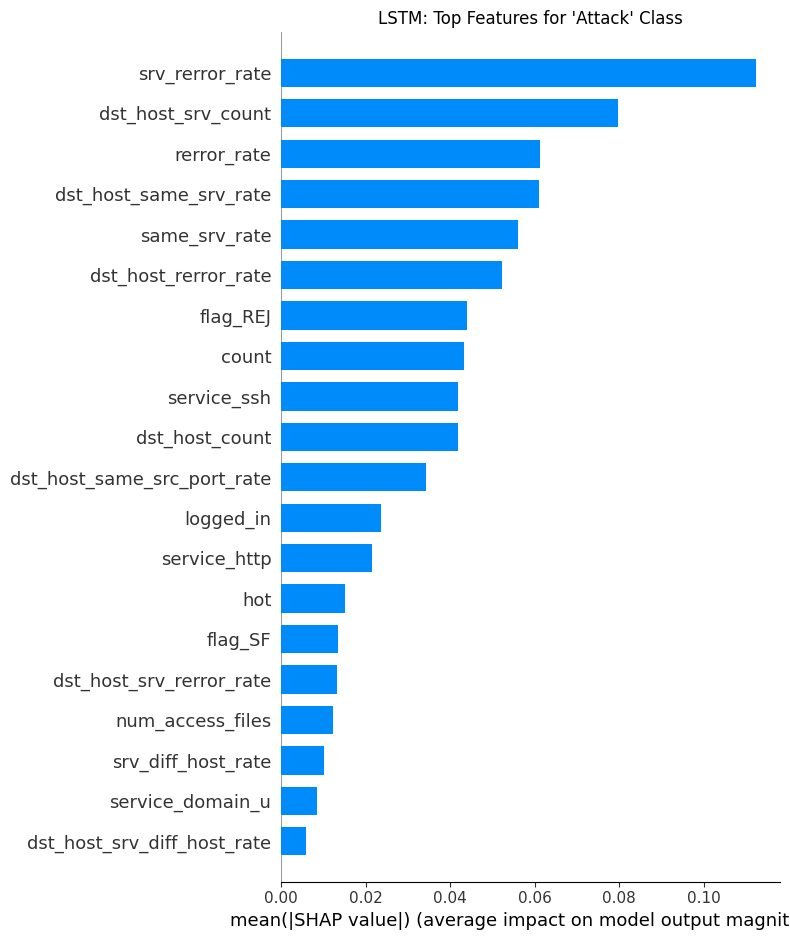

------------------------------

--- Phase 3 Complete: All Models Explained ---


In [3]:
# CELL 2: THE "EXPLAINER" SCRIPT (Version 8)
# -----------------------------------------------
# This script runs AFTER Cell 1.
# It imports 'shap', loads the models and data from disk,
# and generates our final XAI plots.
#
# !! THIS VERSION FIXES THE FINAL ASSERTION ERROR !!
# The call to shap.summary_plot for the Random Forest
# has been simplified to remove the conflicting 'features' argument.
#
# INSTRUCTIONS FOR COLAB:
# 1. Ensure Cell 1 has run successfully.
# 2. Run this cell.

# Step 1: Install and Import SHAP
!pip install shap
print("\n--- SHAP Library Installed ---")
import shap
import joblib
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os # Import os to check for files

print(f"SHAP Version: {shap.__version__}")
print("-" * 30)

# ------------------------------------------
# STEP 2: LOAD MODELS AND DATA FROM DISK
# ------------------------------------------

print("--- Loading models and data from disk... ---")
if not (os.path.exists('rf_model.joblib') and os.path.exists('lstm_model.h5') and os.path.exists('shap_data.pkl')):
    print("--- ERROR ---")
    print("Could not find model files. Please re-run the 'Trainer' script (Cell 1) first.")
    print("-" * 30)
else:
    # Load the Random Forest model
    rf_classifier = joblib.load('rf_model.joblib')

    # Load the LSTM model
    lstm_model = tf.keras.models.load_model('lstm_model.h5')

    # Load all the data
    with open('shap_data.pkl', 'rb') as f:
        data = pickle.load(f)

    X_train_reshaped = data['X_train_reshaped']
    X_test_df = data['X_test_df']
    X_test_reshaped = data['X_test_reshaped']
    feature_names = data['feature_names']

    print("--- All files loaded successfully! ---")
    print("-" * 30)


    # Step 3: Explain the "Baseline" (Random Forest)
    print("--- Starting XAI Analysis for Random Forest ---")

    # We use the loaded DataFrame sample
    X_test_sample_rf = X_test_df.iloc[:500]

    explainer_rf = shap.TreeExplainer(rf_classifier)
    shap_values_rf = explainer_rf.shap_values(X_test_sample_rf)

    print("--- Generating Plot 1: Random Forest Feature Importance ---")
    plt.title("Random Forest: Top Features for 'Attack' Class")

    # ------------------------------------------
    # !! THE FIX IS HERE (VERSION 8) !!
    # We pass *only* the SHAP values (for class 1) and the feature_names list.
    # This avoids the data matrix comparison error.
    # ------------------------------------------
    shap.summary_plot(
        shap_values_rf[1],
        feature_names=feature_names,
        plot_type="bar",
        show=False
    )
    plt.show()
    print("-" * 30)


    # Step 4: Explain the "Promise" (LSTM)
    print("--- Starting XAI Analysis for LSTM ---")

    # We use the robust `GradientExplainer`
    background = X_train_reshaped[np.random.choice(X_train_reshaped.shape[0], 100, replace=False)]
    explainer_lstm = shap.GradientExplainer(lstm_model, background)

    test_sample_reshaped = X_test_reshaped[np.random.choice(X_test_reshaped.shape[0], 100, replace=False)]
    shap_values_lstm = explainer_lstm.shap_values(test_sample_reshaped)

    shap_values_lstm_2d = shap_values_lstm[0].reshape(-1, len(feature_names))

    print("--- Generating Plot 2: LSTM Feature Importance ---")
    plt.title("LSTM: Top Features for 'Attack' Class")

    shap.summary_plot(
        shap_values_lstm_2d,
        feature_names=feature_names,
        plot_type="bar",
        show=False
    )
    plt.show()
    print("-" * 30)

print("\n--- Phase 3 Complete: All Models Explained ---")